# Implicit Bias of SGD for Diagonal Linear Networks - Simulations

In [65]:
# Preliminary imports
import numpy as np
import scipy.linalg as sp
from random import randint
%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

Reference EPFL paper from Scott Pesme, Loucas Pillaud-Vivien and Nicolas Flammarion from the 35th Conference  on Neural Information Processing Systems (NeurIPS 2021): [link.](https://proceedings.neurips.cc/paper/2021/file/f4661398cb1a3abd3ffe58600bf11322-Paper.pdf)

In this notebook, we recreate the paper's authors' results numerically, plotting the resulting gradients and its marginals. Since the SGF converges to a sparse solution, we expect marginals of the SGD's solution to exhibit a delta at 0.

Setting up the computations:
Firstly, we compute the nonlinear parametrisation:
$$
\beta_w = \beta(w) = w_{+}^2 - w_{-}^2 \in \mathbb{R}^d
$$
where
$$
w = \begin{bmatrix}w_+ \\ w_- \end{bmatrix} \in \mathbb{R}^{2d} \ \text{and } u\in \mathbb{R}^d \implies u^2 = u \odot u \in \mathbb{R}^d
$$

In [66]:
def b_w(w_upper, w_lower):
    """
    Nonlinear parametrisation computation
    Arguments:
    - w_upper: d dimensional numpy array, upper half of the gradient
    - w_lower: d dimensional numpy array, lower half of the gradient
    
    Output:
    d dimensional parametrisation of the gradient
    """
    return w_upper ** 2 - w_lower ** 2

We will compute an SGD gradient step using:
$$
w_{t+1,\pm} = w_{t,\pm}\mp\gamma\langle\beta_{w_t}-\beta^*, x_{i_t}\rangle x_{i_t} \odot w_{t, \pm}
$$
where 
$$
X\beta^* = y
$$
and
$$
i_t \sim \text{DiscreteUnif}[1,n]
$$

In [67]:
def stochastic_gradient_step(w_upper, w_lower, s, X, beta, sample_i=None):
    """
    Computes one gradient step for a random sample.
    Arguments:
    - Current gradient as (w_upper, w_lower) - each being d dimensional np arrays
    - s: step size, double
    - X: input data, n x d
    - beta: interpolating parameter, d dimensional
    
    Output:
    Gradient as the two components of a 2-uple
    """
    x_i = X[randint(0, X.shape[0]-1) if sample_i is None else sample_i]
    k = s * ((b_w(w_upper, w_lower) - beta) @ x_i)
    return (w_upper - k * (x_i * w_upper), w_lower + k * (x_i * w_lower))

Making sure this code is okay so far:

In [68]:
u = np.array([1, 2])
v = np.array([3, 3])
uv_expected = np.array([1-9, 4-9])
uv_computed = b_w(u,v)

if np.ma.allequal(uv_expected,uv_computed):
    print(f"b_w correctly computed {uv_expected}.")
else:
    print(f"Error in b_w: computed {uv_computed}, expected {uv_expected}.")

b_w correctly computed [-8 -5].


In [69]:
s = 0.5
x = np.array([2, 3])
beta = np.array([5, 6])
grad_uv_expected_high, grad_uv_expected_low = np.array([60, 179]), np.array([-174, -262.5])
grad_uv_computed_high, grad_uv_computed_low = stochastic_gradient_step(u, v, s, np.array([x.T]), beta)

comparison_up = np.allclose(grad_uv_expected_high, grad_uv_computed_high)
comparison_low = np.allclose(grad_uv_expected_low, grad_uv_computed_low)

if comparison_up and comparison_low:
    print(f"gradient_step correctly computed {grad_uv_computed_high} and {grad_uv_computed_low}.")
else:
    print(f"Error in gradient_step:")
    print(f"computed upper {grad_uv_computed_high}, expected {grad_uv_expected_high};")
    print(f"computed lower {grad_uv_computed_low}, expected {grad_uv_expected_low}.")

gradient_step correctly computed [ 60. 179.] and [-174.  -262.5].


Additionnally, we define the full gradient and perform a full gradient step:

$$
\nabla_{w_\pm}L(w) = \pm\left[\frac{1}{n}X^TX(\beta_w - \beta^*)\right] \odot w_{\pm}
$$
$$
w_{t+1} = w_t - \gamma \nabla_{w}L(w_t)
$$

In [1]:
def full_gradient_step(w_upper, w_lower, s, X, beta):
    """
    Computes one gradient step over all samples.
    Arguments:
    - Current gradient as (w_upper, w_lower) - each being d dimensional np arrays
    - s: step size, double
    - X: input data, n x d
    - beta: interpolating parameter, d dimensional
    
    Output:
    Gradient as the two components of a 2-uple
    """
    common = s * (X.T @ (X @ ((b_w(w_upper, w_lower) - beta)/n)))
    return (w_upper - common * w_upper, w_lower + common * w_lower)

Now, we generate $n$ gaussian $d$ dimensional input samples:

In [71]:
def generate_inputs(n, d, mean=0.0, std=1.0):
    """
    Generate a n x d matrix with entries ~ N(mean, std). Input samples are lines of this matrix.
    """
    return np.random.normal(loc=mean, scale=std, size=(n , d))

In [72]:
print(generate_inputs(2, 3))

[[ 0.68117266  0.02653065 -0.89305429]
 [ 0.99696813  1.03206332  0.60134802]]


Next, generate an initialisation parameter $\alpha \in (\mathbb{R}_+^*)^d$ uniformly, recalling that:
- "Small initialisations lead to low $l_1$-norm solutions" with good generalisation properties (rich regime);
- "Large initialisations lead to low $l_2$-norm solutions" (kernel or lazy regime).

In [73]:
def generate_unif(min_value, max_value, d):
    """
    Generate a uniformly distributed d dimensional array with components in [min_value, max_value].
    """
    return np.random.uniform(min_value, max_value, size=(d,))

In [74]:
print(generate_unif(0.01, 0.05, 3))

[0.02984675 0.04063206 0.02490984]


We can generate $\beta^*$ with the same function as $\alpha$ (at least for now). Finally, we compute an adequate step size $\gamma$ in order to apply Theorem 1, page 6 from the main paper:
$$
\gamma \leq O\left(\left[\ln\left(\frac{4}{p}\right)\lambda_{\text{max}}\max\left\{||\beta_{l_1}^*||_1\ln\left(\frac{||\beta_{l_1}^*||}{\min_i \alpha_i^2}\right), ||\alpha||_2^2\right\}\right]^{-1}\right)
$$

In [75]:
def generate_gamma(p, X, a, b, safety_factor = 0.5):
    """
    Generate a step size within the conditions of theorem 1.
    
    Important note: 1-p and NOT p is the probability of converging to the presented solution.
    """
    lambda_max = np.linalg.eigvals(X.T @ (X/X.shape[0]))[0]
    beta_1 = np.linalg.norm(beta, ord=1)
    min_ai = np.min(a ** 2)
    a_2 = np.linalg.norm(a, 2) ** 2
    m = 0
    if beta_1 > 0:
        m = beta_1 * np.log(beta_1/min_ai)
    return safety_factor/(np.log(4/p) * lambda_max * max([m, a_2])).real

In [76]:
print(generate_gamma(0.01, generate_inputs(50, 200), generate_unif(0.01, 0.3, 200), generate_unif(-10, 10, 200)))

8.249629874866925e-05


Lastly, we prepare the simulation:

In [77]:
def run(n, d, steps, sample_freq=10, input_mean=0, input_std=1, a_min=0.01, a_max=0.3, b_min=-10, b_max=10, p=0.01, 
        override_gamma = None, override_alpha = None, override_beta = None, override_X = None, 
        gradient_step=stochastic_gradient_step):
    """
    Train the network for a given number of steps.
    
    Output:
    Two halves of the gradient as well as the training set and the interpolating parameter
    for further statistical usage. Also returns history.
    """
    def default_or_compute(default_value, generator):
        if not default_value is None:
            return default_value
        return generator()
    
    X = default_or_compute(override_X, lambda: generate_inputs(n, d, input_mean, input_std))
    a = default_or_compute(override_alpha, lambda: generate_unif(a_min, a_max, d))
    b = default_or_compute(override_beta, lambda: generate_unif(b_min, b_max, d))
    s = default_or_compute(override_gamma, lambda: generate_gamma(p, X, a, b))
    
    samples_length = int(steps/sample_freq)
    w_upper_history = np.array([a] * samples_length)
    w_lower_history = np.array([a] * samples_length)
    step_number = np.array([0] * samples_length)
    
    w_upper = a
    w_lower = np.copy(a)
    j = 1
    for k in range(steps):
        w_upper, w_lower = gradient_step(w_upper, w_lower, s, X, b)
        
        if k % sample_freq == 0 and k != 0:
            w_upper_history[j] = w_upper
            w_lower_history[j] = w_lower
            step_number[j] = k
            j += 1
        
    return w_upper, w_lower, X, b, w_upper_history, w_lower_history, step_number

We can now run some statistics...

In [78]:
def mse(X, beta, w_upper, w_lower):
    """
    Computes the mean squared error.
    """
    return ((X @ (beta - b_w(w_upper, w_lower))) ** 2).mean()

def test_error(new_n, d, beta, w_upper, w_lower, input_mean=0, input_std=1):
    X_new = generate_inputs(new_n, d, input_mean, input_std)
    return mse(X_new, beta, w_upper, w_lower)

def training_error(X, beta, w_upper, w_lower):
    return mse(X, beta, w_upper, w_lower)

... and plot results.

In [1]:
def plot_error_history(w_upper_history, w_lower_history, X, b, step_number, new_test_n, d, steps, 
                 input_mean=0, input_std=1):
    """
    Matplotlib utility function to plot training and test errors.
    """
    training_errors = [training_error(X, b, w_upper_history[j], w_lower_history[j]) for j in range(len(w_upper_history))]
    test_errors = [test_error(new_test_n, d, b, w_upper_history[j], w_lower_history[j]) for j in range(len(w_upper_history))]
    plt.plot(step_number, training_errors, color = 'g', label = "Training error")
    plt.plot(step_number,test_errors, color='r', label = "Test error")
    plt.xlabel("Steps")
    plt.ylabel("Error")
    plt.legend(loc="upper right")
    # plt.savefig(f"n={X.shape[0]}_d={X.shape[1]}_steps={steps}_testn={new_test_n}.png")

Time to testrun the algorithm! 

In [80]:
%%time
steps = 50000
n = 100
d = 100
a = 5
w_up, w_low, X, b, w_up_hist, w_low_hist, samples_hist = run(n, d, steps)

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.24 s


In [81]:
print(training_error(X, b, w_up, w_low))
print(test_error(1000, d, b, w_up, w_low))

7.512085342250266
655.3406384813135


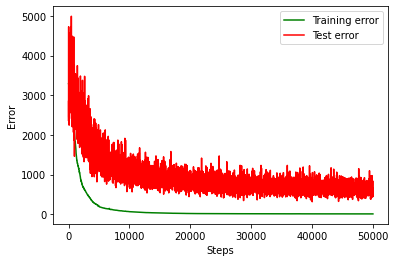

In [82]:
%matplotlib inline
plot_error_history(w_up_hist, w_low_hist, X, b, samples_hist, 50, d, steps)

Beyond the training and test error, our aim is to observe and possibly quantify sparsity of the final gradient. First, a histogram and a plot of $w$'s coefficients:

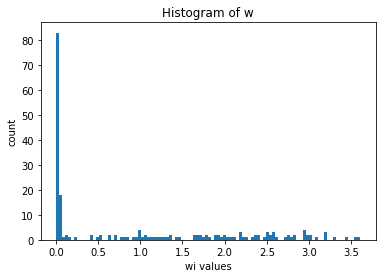

In [83]:
%matplotlib inline
w = np.hstack([w_up, w_low])
plt.hist(w, bins = 100)
plt.xlabel("wi values")
plt.ylabel("count")
plt.title("Histogram of w")
plt.show()

Text(0.5, 1.0, 'Plotting w quantiles')

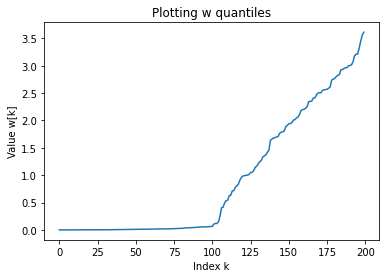

In [84]:
%matplotlib inline
sorted_w = sorted(w)
plt.plot(sorted_w)
plt.xlabel("Index k")
plt.ylabel("Value w[k]")
plt.title("Plotting w quantiles")

The same with $\beta_w$:

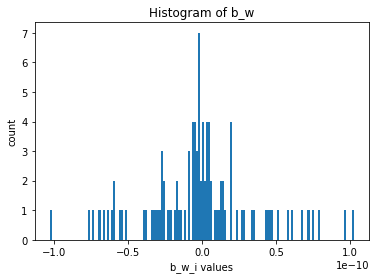

In [104]:
%matplotlib inline
plt.hist(b_w(w_up, w_low), bins = 150)
plt.xlabel("b_w_i values")
plt.ylabel("count")
plt.title("Histogram of b_w")
plt.show()

Text(0.5, 1.0, 'Plotting b_w quantiles')

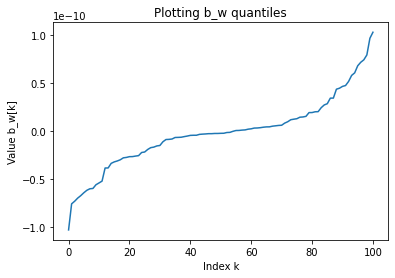

In [105]:
%matplotlib inline
sorted_bw = sorted(b_w(w_up, w_low))
plt.plot(sorted_bw)
plt.xlabel("Index k")
plt.ylabel("Value b_w[k]")
plt.title("Plotting b_w quantiles")

Notice the scales of the $\beta_w$ plots: we indeed observe a remarkable sparsity in the final gradient $w$ - about half the coefficients are 0 - as well as $\beta_w$ where all coefficients have an absolute value $ < 10^{-10}$. To plot the marginals of both $w$ and $\beta_w$:

In [108]:
%%time
iterations = 100

steps = 100000
n = 100
d = 102

# Maintain the same inputs throughout all the runs.
p = 0.01
gen_X = generate_inputs(n, d)
gen_b = generate_unif(-10, 10, d)
gen_a = generate_unif(0.01, 0.3, d)
gen_s = generate_gamma(p, gen_X, gen_a, gen_b)

w_up_avg = np.zeros(d)
w_low_avg = np.zeros(d)
w_up_hist = np.zeros((iterations, d))
w_low_hist = np.zeros((iterations, d))

for k in range(iterations):
    w_up, w_low, _, _, _, _, _ = run(n, d, steps, sample_freq=steps, p=p, 
                                                                 override_X=gen_X, override_alpha=gen_a,
                                                                 override_beta=gen_b, override_gamma=gen_s)
    w_low_hist[k] = w_low
    w_up_hist[k] = w_up
    w_up_avg += w_up
    w_low_avg += w_low
    
w_up_avg = (1/iterations) * w_up_avg
w_low_avg = (1/iterations) * w_low_avg

CPU times: user 2min 38s, sys: 0 ns, total: 2min 38s
Wall time: 2min 39s


In [109]:
def plot_marginal(u, bins=100):
    %matplotlib inline
    plt.hist(u, density=True, bins=bins)

Text(0.5, 1.0, 'Marginal of w')

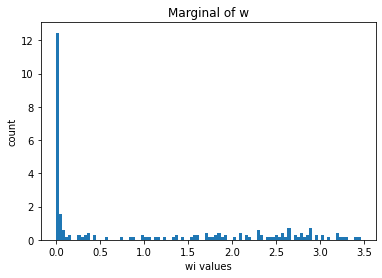

In [110]:
plot_marginal(np.hstack(np.array([w_up_avg, w_low_avg])))
plt.xlabel("wi values")
plt.ylabel("count")
plt.title("Marginal of w")

Text(0.5, 1.0, 'Marginal of b_w')

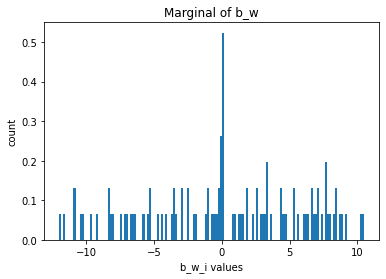

In [111]:
plot_marginal(b_w(w_up_avg, w_low_avg), bins=150)
plt.xlabel("b_w_i values")
plt.ylabel("count")
plt.title("Marginal of b_w")

We observe that in $w_{\infty}$ each coefficient is $0$ with high probability, and the same goes for $\beta_\infty$.

We can also compute:
$$
\mathbb{E}\left[||\beta - \beta^*||^2\right]
$$
in the following cell:

In [112]:
sqeuclidean = lambda x: np.inner(x, x)
differences = b_w(w_up_hist, w_low_hist) - gen_b
squared_norms = [sqeuclidean(b_w(w_up_hist[j], w_low_hist[j]) - gen_b) for j in range(w_up_hist.shape[0])]
mean = np.mean(squared_norms)

print(f"E[||b-b*||^2] = {mean}")
print(f"std(||b - b*||^2) = {np.std(squared_norms)}") 
print(f"E[(b-b*) component-wise] = {differences.mean()}") # E(marginal of (b-b*))
print(f"std((b-b*) component-wise) = {differences.std()}") # std(marginal of (b-b*))

E[||b-b*||^2] = 262.8804713304351
std(||b - b*||^2) = 1.867381946349515
E[(b-b*) component-wise] = -0.002969618185369124
std((b-b*) component-wise) = 1.6053817939092359


## Characterizing the distribution of beta

Now, let's explore a different path and try to check that:
$$
\beta_\infty^\alpha = \arg \min\left\{\phi_\alpha(\beta) \ | \ \beta \in \mathbb{R}^d, \ X\beta = y\right\}
$$
where:
$$
\phi_{\alpha}(\beta) = \frac{1}{4}\sum_{i=1}^d \beta_i \sinh^{-1}\left(\frac{\beta_i}{2\alpha_i^2}\right)-\sqrt{\beta_i^2 + 4\alpha_i^4} = \frac{1}{4}\sum_{i=1}^d \phi_{\alpha_i}(\beta_i)
$$
We first compute $\frac{\partial \phi_{\alpha}}{\partial \beta_i}(\beta) = \frac{1}{4}\phi_{\alpha_i}'(\beta_i)$:
$$
\phi_{\alpha_i}'(\beta_i) = \sinh^{-1}\left(\frac{\beta_i}{2\alpha_i^2}\right)
$$
And thus, applying $\sinh^{-1}$ component-wise:
$$
\nabla \phi_{\alpha}(\beta) = \frac{1}{4}\left[\sinh^{-1}\left(\frac{\beta_i}{2\alpha_i^2}\right)\right]_{1 \leq i \leq d} = \frac{1}{4}\sinh^{-1}\left(\frac{\beta}{2\alpha^2}\right)
$$
Finally, we compute the Hessian, which is a diagonal matrix:
$$
H_{\phi_{\alpha}}(\beta) = \frac{1}{4}\text{diag}\left[\frac{1}{\sqrt{\beta_i^2 + 4\alpha_i^4}}\right]_{1 \leq i \leq d}
$$
Note: $\phi_{\alpha}(\beta) = 0 \iff \beta = 0$, which is a (global) minimum since $H_{\phi_{\alpha}}(0)$ is positive definite since all of its eigenvalues are positive.

In fact, since $H_{\phi_{\alpha}}(\beta)$ is positive definite $\forall \beta \in \mathbb{R}^d$, $\phi_{\alpha}$ is **convex** (strongly convex, even)! Let's then simplify the constrained optimization problem, reducing it to an unconstrained optimisation problem by considering $y = 0$, thus $X\beta = 0$ and thus $\beta^* = 0$ is an interpolating parametrization of the gradient.

In [113]:
%%time
steps = 100
n = 100
d = 100

beta = np.zeros(d) # beta* = 0!

w_up, w_low, X, b, w_up_hist, w_low_hist, samples_hist = run(n, d, steps, sample_freq = 1,
                                                            override_beta = beta)

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 63.2 ms


In [114]:
print(training_error(X, b, w_up, w_low))

0.0


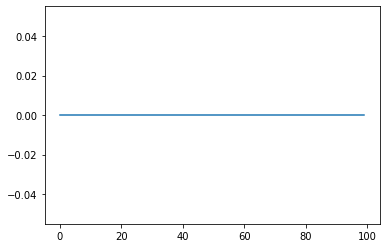

In [115]:
%matplotlib inline
bw = b_w(w_up, w_low)
plt.plot(bw)

The SGD has indeed converged to $\beta^* = 0$ (and super quickly too), let's check the history of the norm of $\beta_w$:

In [116]:
def plot_norm_history(w_up_hist, w_low_hist, sample_times, ylim=1e-12):
    plt.plot(sample_times, np.linalg.norm(b_w(w_up_hist, w_low_hist), axis=1))
    plt.ylim(-ylim, ylim)

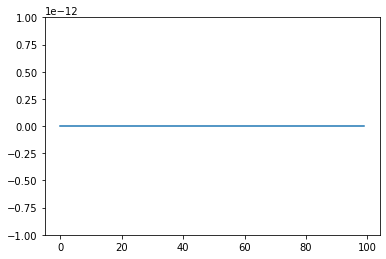

In [117]:
plot_norm_history(w_up_hist, w_low_hist, samples_hist)

Let's try to tickle this lightspeed convergence a bit by initialising further from $0$ - recall that the initialisation $\alpha$ is, by default, a random vector where each component $\alpha_i \sim^{\text{iid}} \text{Unif}[0.01,0.3]$. Let's push the uniform mean further:

In [118]:
%%time
steps = 5 #VERY few steps...
n = 100
d = 100

beta = np.zeros(d) 
alpha = generate_unif(300, 1000, d)

w_up, w_low, X, b, w_up_hist, w_low_hist, samples_hist = run(n, d, steps, sample_freq = 1,
                                                            override_beta = beta,
                                                            override_alpha = alpha)

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 87.5 ms


In [119]:
print(training_error(X, b, w_up, w_low))

0.0


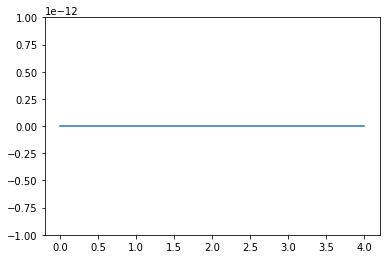

In [120]:
plot_norm_history(w_up_hist, w_low_hist, samples_hist)

That's weird. How can $\beta_{w_t} = 0$ at all times? That's actually thanks to the initialisation. Recall that $w_{0,+} = w_{0,-} = \alpha$, thus $b_{w_0} = a^2 - a^2 = 0$. Computing the first gradient update:
$$
w_{1,\pm} = w_{0,\pm}\mp\gamma\langle\beta_{w_0}-\beta^*, x_{i_0}\rangle x_{i_0} \odot w_{0, \pm} = w_{0,\pm}\mp\gamma\langle 0-0, x_{i_0}\rangle x_{i_0} \odot w_{0, \pm} = w_{0,\pm}
$$

By induction, it follows that $\forall t \ w_{t} = w_0$, thus $\forall t \ \beta_{w_t} = \beta_{w_0} = 0$.

Let's try to make this more interesting by choosing $\beta^* \in \ker(X) \setminus \{0\}$, e.g. $\beta^*$ a basis vector of $\ker(X)$. This time:
$$
\begin{align}
w_{t+1,\pm} &= w_{t,\pm}\mp\gamma\langle\beta_{w_t}-\beta^*, x_{i_t}\rangle x_{i_t} \odot w_{t, \pm} \\
&= w_{t,\pm}\mp \left(\gamma\langle\beta_{w_t}, x_{i_t}\rangle x_{i_t} \odot w_{t, \pm}-\gamma\underbrace{\langle\beta^*, x_{i_t}\rangle}_{=0} x_{i_t} \odot w_{t, \pm}\right) \\
&= w_{t,\pm}\mp \gamma\langle\beta_{w_t}, x_{i_t}\rangle x_{i_t} \odot w_{t, \pm}
\end{align} 
$$

In [121]:
def project(u, v):
    """
    Project u on to v, with ||v|| = 1.
    """
    return np.dot(u,v) * v

In [122]:
%%time
steps = 3500
n = 100
d = n + 1 #need d > n to ensure that dim(ker(X)) > 0

computed_X = generate_inputs(n, d)
norm = 400000
beta = sp.null_space(computed_X).T[0] #null_space computes an orthonormal basis, therefore ||beta|| = 1
alpha = generate_unif(1, 10, d)
alpha = alpha - project(alpha, beta) #pick initialisation at an orthogonal direction from beta

w_up, w_low, X, b, w_up_hist, w_low_hist, samples_hist = run(n, d, steps, sample_freq = 1,
                                                            override_beta = norm * beta,
                                                            override_alpha = alpha,
                                                            override_X = computed_X)

CPU times: user 846 ms, sys: 0 ns, total: 846 ms
Wall time: 820 ms


In [123]:
print(training_error(X, b, w_up, w_low))

5.469481311542245e-20


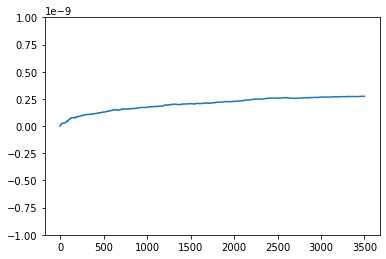

In [124]:
plot_norm_history(w_up_hist, w_low_hist, samples_hist, ylim=1e-9)

With a random (usually non orthogonal) initialisation, $\beta_{w_t}$ is very close to $0$ at all times.